In [20]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')


In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp


In [89]:
sns.set_context('paper')

### Catalytic Promiscuity in the Biosynthesis of Cyclic Peptide in Planktonic Marine Cyanobacteria, PNAS2010
Detection of procM and procA gene sequences in marine cyanobacterial genomes.
1. **procM** gene sequences were detected in marine cyanobacterial genomes using the **pre-computed phylogenetic tree viewer in the microbesonline database** (http://www.microbesonline.org (3), which is computed using FastBLAST (4), see http://www.microbesonline.org/treebrowseHelp.html for additional details). 
2. **procA** sequences were detected in the genomes of Prochlorococcus **MIT9313** by **manually searching for short ORFs close to the procM gene** that encoded a **peptide** with a **leader sequence** followed by a **double-glycine** protease recognition site and a **short** core peptide rich in **Cys, Ser and Thr** residues (Fig. 1C). 
3. Once several such putative lantipeptides were discovered, we used **BLASTp** in both **microbesonline** and the **NCBI nr** database (with a cutoff **e-value of 10**) to detect other, similar genes in cyanobacterial genomes
4.  **manually** checked the resulting peptide sequences to verify that they agreed with the definition of procAs, as described above. 
5. Figure 1 and Figure S1 were produced using IMG (http://img.jgi.doe.gov/cgi-bin/pub/main.cgi).

### Evolutionary radiation of lanthipeptides in marine cyanobacteria, PNAPLUS 2017
1. Annotation of **prochlorosin** biosynthesis genes was performed manually using **BLAST** (12). 
2. The sequences of the **ProcM, LanT and LanOM** proteins from Prochlorococcus **MIT9313** were used as queries for the search of homologous proteins. 
3. Top hits were further inspected against the **NCBI Conserved Domain Database (CDD)** (13) to verify the presence of signature domains.
4. The **tBLASTn** algorithm was used to search **procA and procA pseudogenes** using a **consensus sequence** derived from **29 prochlorosin leader peptide** sequences from Prochlorococcus **MIT9313**. 
5. BLAST hits with **>45% identity** and **E-val <0.001** were inspected against the CDD to confirm the presence of the **nif11-like leader peptide domain**.


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735
    http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798
        https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc
            http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m
            https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [70]:
def analyze_aa_seq(row):
    aa_sequence = str(row['aa_sequence'])
    aa_length = len(aa_sequence)
    gg_index = aa_sequence.find('GG')
    ga_index = aa_sequence.find('GA')
    aa_core_sequence = None
    core_length = None
    count_dict = dict()
    precent_dict = dict()
    CST_precent = None
    if gg_index != -1:
        aa_core_sequence = aa_sequence[gg_index+2:]
        core_length = len(aa_core_sequence)
        if core_length > 0:
            c = Counter(aa_core_sequence)
            count_dict = {'core_' + i : v for i, v in c.items()}
            precent_dict = {'core_precent_' + i : v/core_length for i, v in c.items()}
            CST_precent = (precent_dict.get('core_precent_C', 0) + 
                           precent_dict.get('core_precent_T', 0) + 
                           precent_dict.get('core_precent_S', 0)) 
    res_dict = {
        'aa_length' :  aa_length,
        'gg_index' : gg_index,
        'ga_index' : ga_index,
        'aa_core_sequence' : aa_core_sequence,
        'core_length' : core_length,
        'CST_precent' : CST_precent,
        **count_dict,
        ** precent_dict,
    }
    return row.append(pd.Series(res_dict))

In [40]:
def min_index(row):
    gg_index = row['gg_index']
    ga_index = row['ga_index']
    if gg_index == -1: 
        return ga_index
    if ga_index == -1: 
        return gg_index
    return min(ga_index, gg_index)
genome_df['leader_end_index'] = genome_df.apply(min_index, axis=1)


In [41]:
genomes_dpath = r'data\detailed_Prochlorococcus_genome_annotations'
genome_fnames = [ n for n in os.listdir(genomes_dpath) if n.endswith('.txt')]
def _load(fname):
    df = pd.read_csv(os.path.join(genomes_dpath, fname), sep='\t')
    df['genome'] = os.path.basename(os.path.splitext(fname)[0])
    return df
genome_df = pd.concat([_load(fname) for fname in genome_fnames])


In [72]:
df = genome_df.apply(analyze_aa_seq, axis=1)

In [73]:
df.head()

,CST_precent,aa_core_sequence,aa_length,aa_sequence,aliases,contig_id,core_A,core_C,core_D,core_E,...,ga_index,gene_id,genome,gg_index,location,nucleotide_sequence,start,stop,strand,type
0,NaN,NaN,385.0,MEIICNQNELNNAIQLVSKAVASRPTHPILANILLTADEGTNKISV...,NaN,AS9601,NaN,NaN,NaN,NaN,...,66.0,PAS9601_0001,AS9601,-1.0,AS9601_168_1325,atggaaattatttgtaatcaaaatgaattaaataatgctatacaac...,168,1325,+,peg
1,NaN,NaN,235.0,MKLPKEILLSELLNYIVKGNMVLNYGNGENVWMHPPVHRILGWYSR...,NaN,AS9601,NaN,NaN,NaN,NaN,...,-1.0,PAS9601_0002,AS9601,-1.0,AS9601_1327_2034,ttgaaattacctaaagaaattttattaagtgaattattaaattata...,1327,2034,+,peg
2,0.164404,ILRDIFTMGARPIAVLNSLRFGNLDKSSNVDLLRGVVSGIAHYGNC...,779.0,MINHENNDLFDLNEALKVENLTLNDYEEICKRLKRKPNRTELGMFG...,NaN,AS9601,46.0,11.0,39.0,45.0,...,108.0,PAS9601_0003,AS9601,114.0,AS9601_2038_4377,atgataaatcatgaaaataatgatctatttgatcttaatgaagcat...,2038,4377,+,peg
3,NaN,NaN,486.0,MCGIVGIVSSNDVNQQIYDSLLLLQHRGQDSTGIATMENTVFHIHK...,NaN,AS9601,NaN,NaN,NaN,NaN,...,388.0,PAS9601_0004,AS9601,-1.0,AS9601_4425_5885,atgtgcggaatagttggaatcgtttcttcgaatgatgtaaatcaac...,4425,5885,+,peg
4,0.124789,ELIYSRAIEELYQTGKGSITIRGVINTEEVNLGKGKHKKNAIIIKE...,813.0,MDKKNFTSISLQEEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...,NaN,AS9601,16.0,7.0,26.0,47.0,...,333.0,PAS9601_0005,AS9601,218.0,AS9601_8323_5882,atggataagaaaaatttcacttccatatcacttcaagaagaaatgc...,8323,5882,-,peg


In [74]:
df.columns

Index(['CST_precent', 'aa_core_sequence', 'aa_length', 'aa_sequence',
       'aliases', 'contig_id', 'core_A', 'core_C', 'core_D', 'core_E',
       'core_F', 'core_G', 'core_H', 'core_I', 'core_K', 'core_L', 'core_M',
       'core_N', 'core_P', 'core_Q', 'core_R', 'core_S', 'core_T', 'core_V',
       'core_W', 'core_X', 'core_Y', 'core_length', 'core_precent_A',
       'core_precent_C', 'core_precent_D', 'core_precent_E', 'core_precent_F',
       'core_precent_G', 'core_precent_H', 'core_precent_I', 'core_precent_K',
       'core_precent_L', 'core_precent_M', 'core_precent_N', 'core_precent_P',
       'core_precent_Q', 'core_precent_R', 'core_precent_S', 'core_precent_T',
       'core_precent_V', 'core_precent_W', 'core_precent_X', 'core_precent_Y',
       'core_precent_x', 'core_x', 'evidence_codes', 'feature_id', 'figfam',
       'function', 'ga_index', 'gene_id', 'genome', 'gg_index', 'location',
       'nucleotide_sequence', 'start', 'stop', 'strand', 'type'],
      dtype='object')

In [75]:
df.figfam.unique()

array(['FIG00066425', nan, 'FIG01303876', ..., 'FIG025203', 'FIG015100',
       'FIG000212'], dtype=object)

In [80]:
df.shape, genome_df.shape

((92936, 65), (92936, 15))

In [77]:
df.CST_precent.describe()

count    47793.000000
mean         0.131942
std          0.048101
min          0.000000
25%          0.110169
50%          0.130435
75%          0.150754
max          1.000000
Name: CST_precent, dtype: float64

In [78]:
lanm_genes = df.loc[df['function'].str.contains('lanm', case=False)]

In [67]:
lanm_genes = genome_df.loc[genome_df['function'].str.contains('lanm', case=False)]

In [57]:
df['function'].str.contains('lanm', case=False).sum()

138

In [79]:
lanm_genes.genome.value_counts()


MIT0703    1
MIT9303    1
MIT0701    1
MIT9313    1
MIT0702    1
Name: genome, dtype: int64

In [81]:
lanm_genes.head().T


,1769,1794,2701,2316,309
CST_precent,0.138182,0.138182,0.138182,0.134872,0.142163
aa_core_sequence,RAVAVLEFADPNSTPDCSIHVVYKPKDMGVDAAYQGTLADLNAHSD...,RAVAVLEFADPNSTPDCSIHVVYKPKDMGVDAAYQGTLADLNAHSD...,RAVAVLEFADPNSTPDCSIHVVYKPKDMGVDAAYQGTLADLNAHSD...,RAVAVLEFADPNSTANSSMHVVYKPKDMAVDAAYQATLADLNAHSD...,RAVAVLEFADPNSTANSSMHVVYKPKDMAVDAAYQATLADLNTHSD...
aa_length,1082,1082,1082,1074,1074
aa_sequence,MGAAEPLALQSSWKSLWLEAVAADEPHKFKRRLEWDGLTESEFHAA...,MGAAEPLALQSSWKSLWLEAVAADEPHKFKRRLEWDGLTESEFHAA...,MGAAEPLALQSSWKSLWLEAVAADEPHKFKRRLEWDGLTESEFHAA...,MGAAEPLTSPTSWKTSWLAAIAPDEPHKFDRRLEWDELSEENFFAA...,MGAAEPLESPSSWKTSWLAAIAPDEPHKFDRRLEWDELSEENFFAA...
aliases,NaN,NaN,NaN,NaN,NaN
contig_id,contig00017,contig00012,contig00032,MIT9303,MIT9313
core_A,91,91,91,100,93
core_C,19,19,19,15,15
core_D,50,50,50,47,47
core_E,45,45,45,43,45


In [84]:
df1 = df.loc[df.gg_index >0]

In [85]:
df1.shape

(47858, 65)

In [86]:
df1.columns

Index(['CST_precent', 'aa_core_sequence', 'aa_length', 'aa_sequence',
       'aliases', 'contig_id', 'core_A', 'core_C', 'core_D', 'core_E',
       'core_F', 'core_G', 'core_H', 'core_I', 'core_K', 'core_L', 'core_M',
       'core_N', 'core_P', 'core_Q', 'core_R', 'core_S', 'core_T', 'core_V',
       'core_W', 'core_X', 'core_Y', 'core_length', 'core_precent_A',
       'core_precent_C', 'core_precent_D', 'core_precent_E', 'core_precent_F',
       'core_precent_G', 'core_precent_H', 'core_precent_I', 'core_precent_K',
       'core_precent_L', 'core_precent_M', 'core_precent_N', 'core_precent_P',
       'core_precent_Q', 'core_precent_R', 'core_precent_S', 'core_precent_T',
       'core_precent_V', 'core_precent_W', 'core_precent_X', 'core_precent_Y',
       'core_precent_x', 'core_x', 'evidence_codes', 'feature_id', 'figfam',
       'function', 'ga_index', 'gene_id', 'genome', 'gg_index', 'location',
       'nucleotide_sequence', 'start', 'stop', 'strand', 'type'],
      dtype='object')

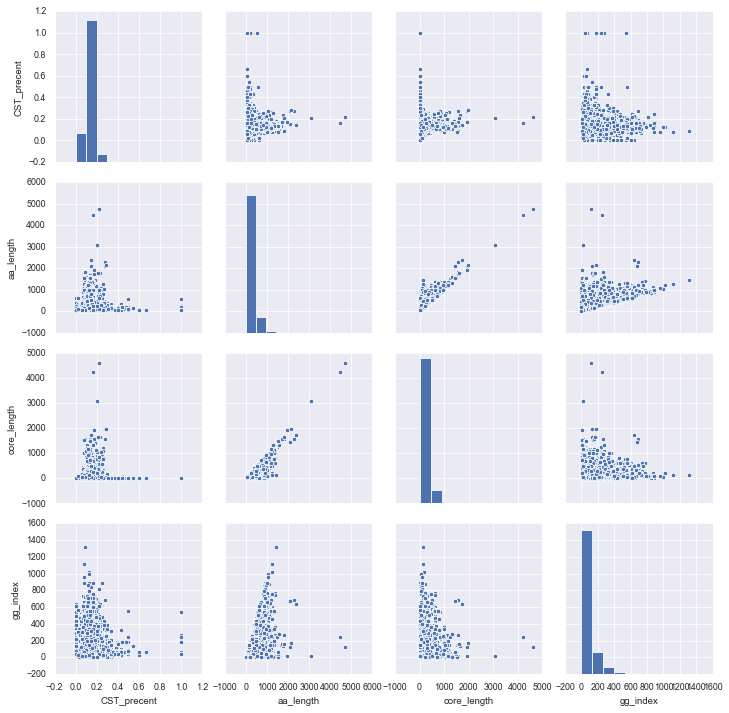

In [90]:
sns.pairplot(data= df[['CST_precent', 'aa_length', 'core_length', 'gg_index']])

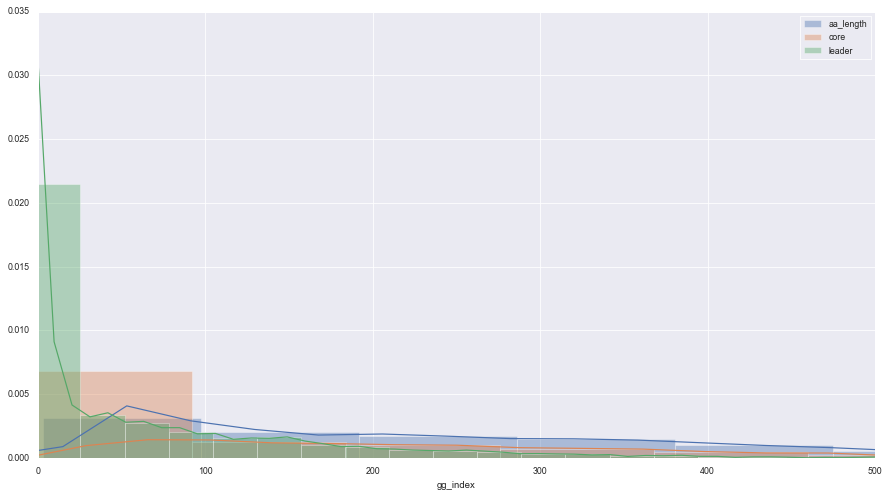

In [111]:
g = sns.distplot(df.aa_length, label='aa_length')
sns.distplot(df.core_length.fillna(0), label='core')
sns.distplot(df.gg_index.fillna(0), label='leader')
g.set(xlim=(0,500))
plt.legend()

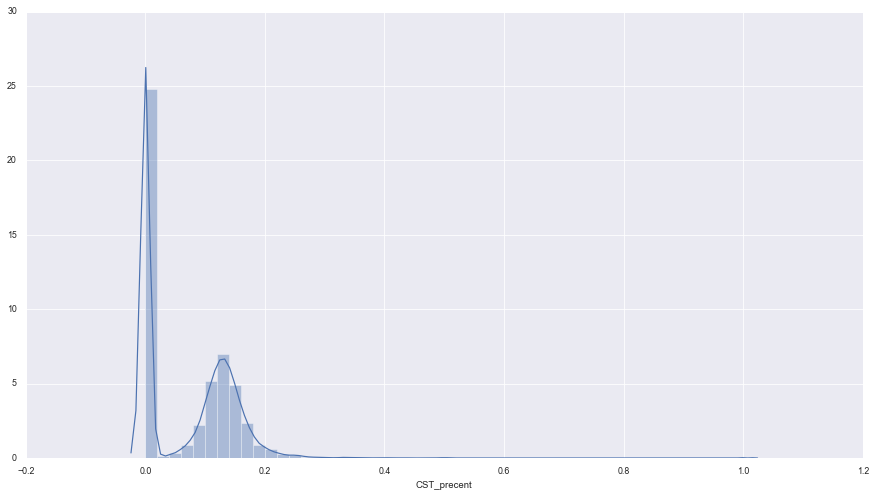

In [95]:
sns.distplot(df.CST_precent.fillna(0))


In [101]:
min_cst_precent = 0.2
max_aa_length = 500
min_core_length = 20
min_gg_index = 10

In [102]:
candidates = df.loc[(df.CST_precent > min_cst_precent) & 
                    (df.aa_length < max_aa_length) &
                    (df.core_length > min_core_length) &
                    (df.gg_index > min_gg_index) 
                   ]

In [103]:
candidates.shape

(1394, 65)

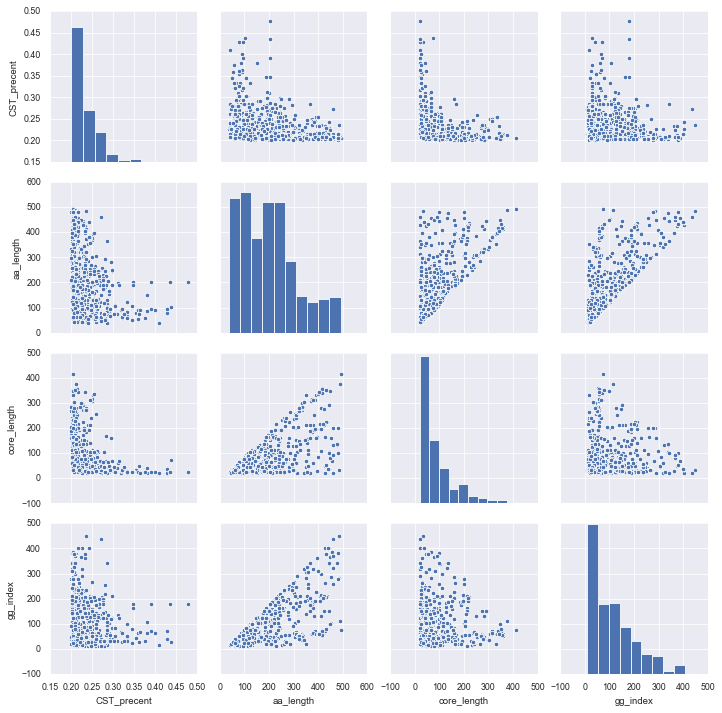

In [104]:
sns.pairplot(data= candidates[['CST_precent', 'aa_length', 'core_length', 'gg_index']])

In [105]:
candidates[['CST_precent', 'aa_length', 'core_length', 'gg_index']].describe()

,CST_precent,aa_length,core_length,gg_index
count,1394.000000,1394.000000,1394.000000,1394.000000
mean,0.234320,201.833572,86.681492,113.152080
std,0.036273,114.032436,73.515295,90.064927
min,0.200758,37.000000,21.000000,11.000000
25%,0.210280,107.000000,32.000000,38.000000
50%,0.222222,189.000000,64.000000,85.000000
75%,0.250000,263.000000,106.000000,164.000000
max,0.478261,491.000000,414.000000,450.000000
